# Predicting Points (Ratings) for each Wine Review
### Text Analytics Final Project

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

import re

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR

## Reading in Data File

In [2]:
df1 = pd.read_csv('winemag_fin.csv', index_col = 0)

C:\Users\Chris Tarzian\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3106: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df1

In [4]:
df = df.drop_duplicates()[['country','description','region_1','points','price']].dropna()
df = df.rename(columns = {'region_1': 'region'})  
df 

,country,description,region,points,price
2,US,"Tart and snappy, the flavors of lime flesh and...",Willamette Valley,87,14.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Lake Michigan Shore,87,13.0
4,US,"Much like the regular bottling from 2012, this...",Willamette Valley,87,65.0
5,Spain,Blackberry and raspberry aromas show a typical...,Navarra,87,15.0
6,Italy,"Here's a bright, informal red that opens with ...",Vittoria,87,16.0
...,...,...,...,...,...
149634,France,Atypically light in body and reticent on the n...,Alsace,84,15.0
149635,US,A Syrah-Grenache blend that's dry and rustical...,Santa Barbara County,84,15.0
149637,US,"Outside of the vineyard, wines like this are w...",California,84,6.0
149638,Argentina,"Heavy and basic, with melon and pineapple arom...",Uco Valley,84,9.0


### Filtering Dataset to contain only Top Regions

In [5]:
df = df[(df["region"]=='Finger Lakes') | (df["region"]=='Alsace')  | (df["region"]=='Rioja') | (df["region"]=='Willamette Valley') | (df["region"]=='Mendoza') | (df["region"]=='Columbia Valley (WA)') | (df["region"]=='Toscana') | (df["region"]=='Napa Valley')]

In [6]:
df.to_csv("wine_regions_final.4.30.csv")

In [7]:
df['region'] = df['region'].copy()
df['reg_num'] = pd.factorize(df['region'])[0]

C:\Users\Chris Tarzian\AppData\Local\Temp\ipykernel_3504\1457417352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'] = df['region'].copy()
C:\Users\Chris Tarzian\AppData\Local\Temp\ipykernel_3504\1457417352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reg_num'] = pd.factorize(df['region'])[0]


In [8]:
df_regions = df
df_regions[['reg_num', 'region']].value_counts()

reg_num  region              
2        Napa Valley             8285
4        Columbia Valley (WA)    7094
3        Mendoza                 4307
0        Willamette Valley       3372
1        Alsace                  2712
7        Rioja                   2578
6        Finger Lakes            2350
5        Toscana                 1990
dtype: int64

### Removing Outliers

In [9]:
Q1 = np.percentile(df['price'], 10,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['price'], 90,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
df = df[df.price < (Q3+1.5*IQR)+1]

Q1 = np.percentile(df['points'], 5, interpolation = 'midpoint')#
 
Q3 = np.percentile(df['points'], 95, interpolation = 'midpoint')
IQR = Q3 - Q1
df = df[df.points < (Q3+1.5*IQR)+1]

In [10]:
df

,country,description,region,points,price,reg_num
2,US,"Tart and snappy, the flavors of lime flesh and...",Willamette Valley,87,14.0,0
4,US,"Much like the regular bottling from 2012, this...",Willamette Valley,87,65.0,0
7,France,This dry and restrained wine offers spice in p...,Alsace,87,24.0,1
9,France,This has great depth of flavor with its fresh ...,Alsace,87,27.0,1
10,US,"Soft, supple plum envelopes an oaky structure ...",Napa Valley,87,19.0,2
...,...,...,...,...,...,...
149617,US,"Bacon, lychee and bubble gum aromas are unexpe...",Finger Lakes,84,13.0,6
149626,US,"Made in a superripe style, this Chard is jammy...",Napa Valley,84,16.0,2
149627,France,Opens with spice aromas that seem a bit unusua...,Alsace,84,21.0,1
149630,US,Tastes kind of soft and thick in jammy cherry ...,Napa Valley,84,27.0,2


### Text Preprocessing

In [11]:
remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z]',' ',x)

tokenize = lambda x: word_tokenize(x)

ps = PorterStemmer()

stem = lambda w: [ ps.stem(x) for x in w ]

lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

remove_stop = lambda x: [w for w in x if w not in stop]

print('Processing : [=', end='')
df['description'] = df['description'].apply(remove_non_alphabets)
print('=', end='')
df['description'] = df['description'].apply(tokenize)
print('=', end='')
stop = text.ENGLISH_STOP_WORDS
df['description'] = df['description'].apply(remove_stop)
print('=', end='')
df['description'] = df['description'].apply(stem)
print('=', end='')
df['description'] = df['description'].apply(leammtizer)
print('=', end='')
df['description'] = df['description'].apply(lambda x: ' '.join(x))
print(']')

Processing : [======]


### Defining Functions for Modeling

In [12]:
def get_sample(df,x):
    df = df.sample(frac=x, replace=False, random_state=1)
    df = df.reset_index(drop=True)
    return df

def tfidf_vector(df):
    
    tfidf_vectorizer=TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1),
                                     max_features=1000)
    
    tfidf_features = tfidf_vectorizer.fit_transform(df.description)  
    
    df_tfidf = pd.DataFrame(tfidf_features.toarray(),
                      columns=tfidf_vectorizer.get_feature_names())
    df_tfidf 
    
    return df_tfidf

def jointwo(df,df_tfidf):
    df = df.join(df_tfidf)
    df = df.drop(columns=['country','description'])
    df = df.fillna(0)
    return df

def run_random_for(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['points']), df.points, test_size=0.30, random_state=42)
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    return regr, X_test, y_test
    
def run_dt(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['points','reg_num']), df.points, test_size=0.30, random_state=42)
    regr = MLPRegressor(random_state=1, max_iter=500)
    regr.fit(X_train, y_train)
    return regr, X_test, y_test

def run_lasso(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['points']), df.points, test_size=0.30, random_state=42)
    regr = linear_model.Lasso(alpha=0.1)
    regr.fit(X_train, y_train)
    return regr, X_test, y_test

### Preparing Data for Modeling

In [13]:
df_tfidf = tfidf_vector(df.reset_index())

C:\Users\Chris Tarzian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
df_tfidf.rename(columns={'price':'pric'},inplace= True)

In [15]:
df_fin = df.reset_index().join(df_tfidf)

In [16]:
cols_to_norm = ['points','price']
df_fin[cols_to_norm] = df_fin[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [17]:
df_fin

,index,country,description,region,points,price,reg_num,absolut,abund,accent,...,yet,yield,you,young,youth,zest,zesti,zin,zinfandel,zippi
0,2,US,tart snappi flavor lime flesh rind domin some ...,Willamette Valley,0.35,0.070922,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,US,much like regular bottl come rough tannic rust...,Willamette Valley,0.35,0.432624,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,France,thi dri restrain wine offer spice profus balan...,Alsace,0.35,0.141844,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,France,thi great depth flavor fresh appl pear fruit t...,Alsace,0.35,0.163121,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,US,soft suppl plum envelop oaki structur cabernet...,Napa Valley,0.35,0.106383,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32176,149617,US,bacon lyche bubbl gum aroma unexpect wholli un...,Finger Lakes,0.20,0.063830,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32177,149626,US,made superrip style chard jammi apricot preser...,Napa Valley,0.20,0.085106,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32178,149627,France,open spice aroma bit unusu rang ginger clove a...,Alsace,0.20,0.120567,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32179,149630,US,tast kind soft jammi cherri blackberri flavor ...,Napa Valley,0.20,0.163121,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sentiment Analysis (Vader)

In [18]:
## note I changed the name of the df below. we can always change it back to og df_fin
wine_sentiment_df = df_fin

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
winescores = [analyzer.polarity_scores(sentence) for sentence in wine_sentiment_df['description']]

In [20]:
compound_s = [i["compound"] for i in winescores]
wine_sentiment_df['Compound_Wine_Score'] = compound_s

In [21]:
wine_sentiment_df['Sentiment_Type']=''
wine_sentiment_df.loc[wine_sentiment_df.Compound_Wine_Score>0,'Sentiment_Type']='POSITIVE'
wine_sentiment_df.loc[wine_sentiment_df.Compound_Wine_Score<=0,'Sentiment_Type']='NEGATIVE'

In [22]:
wine_sentiment_df[['region','reg_num','description', 'points', 'price', 'Compound_Wine_Score','Sentiment_Type']]

,region,reg_num,description,points,price,Compound_Wine_Score,Sentiment_Type
0,Willamette Valley,0,tart snappi flavor lime flesh rind domin some ...,0.35,0.070922,0.0000,NEGATIVE
1,Willamette Valley,0,much like regular bottl come rough tannic rust...,0.35,0.432624,0.6597,POSITIVE
2,Alsace,1,thi dri restrain wine offer spice profus balan...,0.35,0.141844,0.0000,NEGATIVE
3,Alsace,1,thi great depth flavor fresh appl pear fruit t...,0.35,0.163121,0.7506,POSITIVE
4,Napa Valley,2,soft suppl plum envelop oaki structur cabernet...,0.35,0.106383,0.8176,POSITIVE
...,...,...,...,...,...,...,...
32176,Finger Lakes,6,bacon lyche bubbl gum aroma unexpect wholli un...,0.20,0.063830,0.0000,NEGATIVE
32177,Napa Valley,2,made superrip style chard jammi apricot preser...,0.20,0.085106,0.7906,POSITIVE
32178,Alsace,1,open spice aroma bit unusu rang ginger clove a...,0.20,0.120567,0.0000,NEGATIVE
32179,Napa Valley,2,tast kind soft jammi cherri blackberri flavor ...,0.20,0.163121,0.7430,POSITIVE


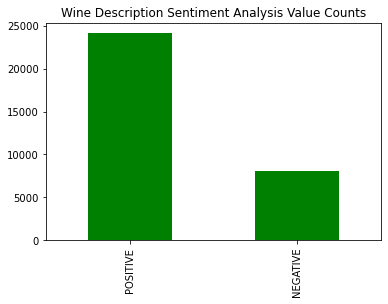

In [23]:
wine_sentiment_df.Sentiment_Type.value_counts().plot(kind='bar',color = 'green',title="Wine Description Sentiment Analysis Value Counts");

[(0.0, 2000.0)]

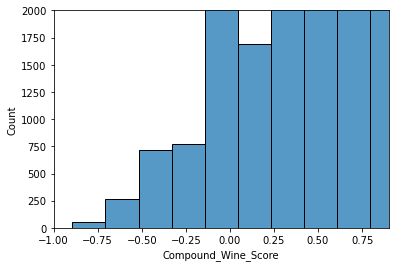

In [24]:
import seaborn as sns
a_plot = sns.histplot(wine_sentiment_df.Compound_Wine_Score,bins=10)
a_plot.set(xlim=(-1,0.9))
a_plot.set(ylim=(0,2000))

In [25]:
df_fin['Compunds'] = wine_sentiment_df.Compound_Wine_Score

In [26]:
df_fin = df_fin.drop(columns= ['Compound_Wine_Score','Sentiment_Type'])

## Machine Learning

### Random Forest

In [27]:
df_ml2 = df_fin.iloc[:,4:]

In [28]:
df_ml2

,points,price,reg_num,absolut,abund,accent,access,accompani,acid,ad,...,yield,you,young,youth,zest,zesti,zin,zinfandel,zippi,Compunds
0,0.35,0.070922,0,0.0,0.0,0.0,0.000000,0.0,0.135196,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
1,0.35,0.432624,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6597
2,0.35,0.141844,1,0.0,0.0,0.0,0.000000,0.0,0.211171,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
3,0.35,0.163121,1,0.0,0.0,0.0,0.000000,0.0,0.191478,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7506
4,0.35,0.106383,2,0.0,0.0,0.0,0.296965,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32176,0.20,0.063830,6,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
32177,0.20,0.085106,2,0.0,0.0,0.0,0.000000,0.0,0.120200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7906
32178,0.20,0.120567,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
32179,0.20,0.163121,2,0.0,0.0,0.0,0.000000,0.0,0.148817,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7430


In [29]:
regr, x_test, y_test = run_random_for(df_ml2)
y_pred = regr.predict(x_test)

In [30]:
print("Random Forest Mean Squared Error (Predict Points):", round(mean_squared_error(y_test, y_pred, squared=False),4))
print("Random Forest R2 Score (Predict Points):", round(r2_score(y_test, y_pred),4))

Random Forest Mean Squared Error (Predict Points): 0.0834
Random Forest R2 Score (Predict Points): 0.7192


### MLP Regressor

In [31]:
regr, x_test, y_test = run_dt(df_ml2)
y_pred = regr.predict(x_test)

In [32]:
print("MLP Regressor Mean Squared Error (Predict Points):", round(mean_squared_error(y_test, y_pred, squared=False),4))
print("MLP Regressor R2 Score (Predict Points):", round(r2_score(y_test, y_pred),4))

MLP Regressor Mean Squared Error (Predict Points): 0.0777
MLP Regressor R2 Score (Predict Points): 0.7563
